In [1]:
import os

### openBLAS will not work properly in jupyter notebook
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
from scipy import stats as ss
import snapatac2 as snap
import scanpy as sc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Impor

In [2]:
snap.__version__

'2.7.0'

## Read RNA metadata

In [3]:
rmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', sep = '\t')
dna = np.unique(rmeta['dna'].dropna())
file_dna = [name + "_processed.h5ad" for name in dna]
print(file_dna)

['QY_2600_processed.h5ad', 'QY_2602_processed.h5ad', 'QY_2604_processed.h5ad', 'QY_2606_processed.h5ad', 'QY_2608_processed.h5ad', 'QY_2610_processed.h5ad', 'QY_2612_processed.h5ad', 'QY_2614_processed.h5ad', 'QY_2616_processed.h5ad', 'QY_2618_processed.h5ad', 'QY_2620_processed.h5ad', 'QY_2622_processed.h5ad', 'QY_2624_processed.h5ad', 'QY_2626_processed.h5ad', 'QY_2661_processed.h5ad', 'QY_2663_processed.h5ad']


In [7]:
### read in pre-processed DNA 
dmeta = []
for i, file in enumerate(file_dna):
    data = snap.read("snapatac/" + file)
    tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns) 
    dmeta.append(tmp_meta[['n_fragment','frac_dup','frac_mito','doublet_probability','doublet_score']])
    data.close()

/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/3163936700.py:5: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  tmp_meta = pd.DataFrame(data.obs[:], index = [dna[i] + ":" + dd for dd in data.obs_names], columns = data.obs[:].columns)
/tmp/ipykernel_1619150/31639

In [7]:
print(len(np.unique([str(element) for element in rmeta['dna']])))
print(len(dmeta))

16
16


In [10]:
rmeta = pd.read_csv('FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', sep = '\t')
cdmeta = pd.concat(dmeta, axis=0)

rmeta['atac_bc'] = rmeta['dna_bc']
rmeta['dna_bc'] = rmeta['dna'].astype(str) + ":" + rmeta['atac_bc'].astype(str)
cdmeta = cdmeta.merge(rmeta, right_on = 'dna_bc', left_index = True)
cdmeta.head()

print(rmeta.shape)
print(cdmeta.shape)

(131297, 28)
(131253, 33)


In [14]:
cdmeta.to_csv("duck.csv")

## Read in DNA data, split and clustering using snapATAC2

In [12]:
data = snap.AnnDataSet(
    adatas = [(name, "snapatac/" + adata) for name, adata in zip(dna, file_dna)],
    filename = "FNIH_Donor_pool.histone.h5ads"
)

### make sure barcode is unique
unique_cell_ids = [sa + ':' + bc for sa, bc in zip(data.obs['sample'], data.obs_names)]
data.obs_names = unique_cell_ids

Unable to create stacked arrays for these keys: fragment_paired
/tmp/ipykernel_1144683/2072313686.py:7: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  unique_cell_ids = [sa + ':' + bc for sa, bc in zip(data.obs['sample'], data.obs_names)]


In [13]:
### Convert to anndata in memory and subset singlet
data = data.to_adata()
tdata = data[np.intersect1d(data.obs.index, cdmeta['dna_bc']),:]

cdmeta.index = cdmeta['dna_bc']
tdata.obs = cdmeta.loc[tdata.obs_names]
tdata.obs = tdata.obs.astype(str)
tdata.write("FNIH_Donor_pool.histone.h5ad")

tdata

/tmp/ipykernel_1144683/1326490887.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  data = data.to_adata()
/tmp/ipykernel_1144683/1326490887.py:2: DeprecationWarning: `Series._import_from_c` is deprecated. use _import_arrow_from_c; if you are using an extension, please compile it with latest 'pyo3-polars'
  data = data.to_adata()
... storing 'n_fragment' as categorical
... storing 'frac_dup' as categorical
... storing 'frac_mito' as categorical
... storing 'doublet_probability' as categorical
... storing 'doublet_score_x' as categorical
... storing 'orig.ident' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'percent.mt' as categorical
... storing 'percent.ribo' as categorical
... storing 'RNA_snn_res.0.3' as categorical
... storing 'seurat_clusters' as categorical
... storing 'doublet_score_y' as categorical


AnnData object with n_obs × n_vars = 131253 × 202081
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'RNA_snn_res.0.3', 'seurat_clusters', 'doublet_score_y', 'doublet_ident', 'DROPLET.TYPE', 'BEST.GUESS', 'NEXT.GUESS', 'rna', 'rna_bc', 'dna', 'library_info', 'dna_bc', 'Donor', 'Batch', 'Target', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'predicted.celltype', 'predicted.celltype_scores', 'predicted.cellsubtype', 'predicted.cellsubtype_scores', 'atac_bc'
    uns: 'AnnDataSet'

In [53]:
### calculate for heatmap
tdata.obs['condition'] = tdata.obs['predicted.celltype'].astype(str) + "_" + tdata.obs['Target'].astype(str)
rpm = snap.tl.aggregate_X(tdata, groupby = 'condition', normalize = "RPM")

drpm = pd.DataFrame(rpm.X, columns = rpm.var_names, index = rpm.obs_names)
drpm.T.to_csv('FNIH_Heart_pool.histone_RPM_by_condition.csv')

## Split into K27ac and K27me3

In [15]:
k27ac_data = tdata[tdata.obs["Target"] == "H3K27ac", :]
k27me3_data = tdata[tdata.obs["Target"] == "H3K27me3", :]

In [16]:
tmp = k27ac_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
# tmp.write("FNIH_Liver_pool_DPT_H3K27ac.h5ad")
k27ac_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 08:47:29 - INFO - Selected 99907 features.
2024-09-17 08:49:09,375 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 08:49:09 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 08:49:13,876 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 08:49:13 - INFO - sklearn.KMeans initialization complete.
2024-09-17 08:49:14,091 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 08:49:14 - INFO - Iteration 1 of 10
2024-09-17 08:49:24,364 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 08:49:24 - INFO - Iteration 2 of 10
2024-09-17 08:49:34,395 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 08:49:34 - INFO - Iteration 3 of 10
2024-09-17 08:49:44,566 - harmonypy - INFO - Iteratio

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [17]:
tmp = k27me3_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
# tmp.write("FNIH_Liver_pool_DPT_H3K27me3.h5ad")
k27me3_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 08:51:33 - INFO - Selected 99876 features.
2024-09-17 08:53:21,125 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 08:53:21 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 08:53:25,160 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 08:53:25 - INFO - sklearn.KMeans initialization complete.
2024-09-17 08:53:25,350 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 08:53:25 - INFO - Iteration 1 of 10
2024-09-17 08:53:34,142 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 08:53:34 - INFO - Iteration 2 of 10
2024-09-17 08:53:42,778 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 08:53:42 - INFO - Iteration 3 of 10
2024-09-17 08:53:47,612 - harmonypy - INFO - Converge

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


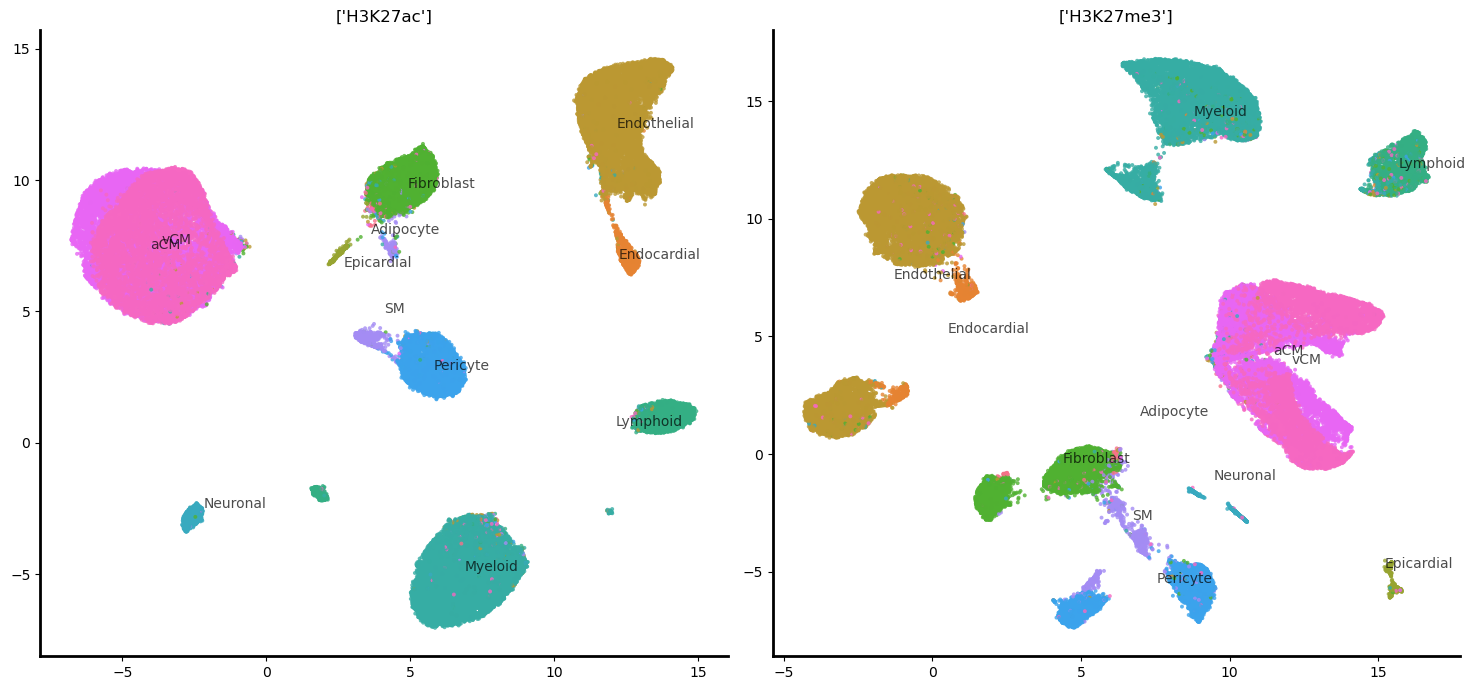

In [19]:
hhue = 'predicted.celltype'

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for i in range(len([k27ac_data, k27me3_data])):
    data = [k27ac_data, k27me3_data][i]
    ttarget = np.unique(data.obs['Target'])
    yi = data.obsm['X_umap']
    lmeta = data.obs

    ax = axes[i]
    sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=ax, s=8, alpha=0.8, #palette = celltype_colors,
                    linewidth=0, hue=lmeta[hhue], legend = False)
    ax.set_title(ttarget)
    sns.despine()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    
    ### manually label point
    representative_points = []
    for cluster in np.unique(lmeta[hhue]):
        cluster_indices = np.where(lmeta == cluster)[0]
        centroid = np.mean(yi[cluster_indices], axis=0)
        representative_points.append(centroid)

    for ii, label in enumerate(np.unique(lmeta[hhue])):
        ax.annotate(label, (representative_points[ii][0], representative_points[ii][1]), fontsize=10, alpha=0.7)


plt.tight_layout()

## Retained only euchromsome for clustering

In [20]:
chrx = [ele for ele in k27ac_data.var_names if 'chrX' in ele]
keep_vars = ~k27ac_data.var_names.isin(chrx)
k27ac_data = k27ac_data[:, keep_vars]

tmp = k27ac_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
k27ac_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 12:25:34 - INFO - Selected 99910 features.
2024-09-17 12:27:42,230 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:27:42 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:27:46,524 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:27:46 - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:27:46,769 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 12:27:46 - INFO - Iteration 1 of 10
2024-09-17 12:27:58,154 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 12:27:58 - INFO - Iteration 2 of 10
2024-09-17 12:28:10,304 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 12:28:10 - INFO - Iteration 3 of 10
2024-09-17 12:28:22,256 - harmonypy - INFO - Iteratio

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [21]:
chrx = [ele for ele in k27me3_data.var_names if 'chrX' in ele]
keep_vars = ~k27me3_data.var_names.isin(chrx)
k27me3_data = k27me3_data[:, keep_vars]

tmp = k27me3_data
snap.pp.select_features(tmp, n_features = 100000,
                        blacklist = "/projects/ps-renlab/y2xie/projects/genome_ref/hg38_CnR_blacklist.bed")
snap.tl.spectral(tmp, weighted_by_sd = True, random_state = 921)
if len(tmp.obs_names) >= 500000:
    k = 50
elif (len(tmp.obs_names) >= 200000 & len(tmp.obs_names) < 500000):
    k = 25
else:
    k = 15

### Batch correction
snap.pp.harmony(tmp, batch = 'library_info')

print("performing leiden clustering...")
snap.pp.knn(tmp, n_neighbors = k, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.umap(tmp, random_state = 921, use_rep = 'X_spectral_harmony')
snap.tl.leiden(tmp, resolution = 0.5, objective_function = 'RBConfiguration',
               use_leidenalg = True, weighted = True)
k27me3_data = tmp

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/snapatac2/preprocessing/_basic.py:976: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['count'] = count
2024-09-17 12:30:36 - INFO - Selected 99870 features.
2024-09-17 12:32:51,050 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:32:51 - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-17 12:32:54,996 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:32:54 - INFO - sklearn.KMeans initialization complete.
2024-09-17 12:32:55,194 - harmonypy - INFO - Iteration 1 of 10
2024-09-17 12:32:55 - INFO - Iteration 1 of 10
2024-09-17 12:33:05,318 - harmonypy - INFO - Iteration 2 of 10
2024-09-17 12:33:05 - INFO - Iteration 2 of 10
2024-09-17 12:33:16,201 - harmonypy - INFO - Iteration 3 of 10
2024-09-17 12:33:16 - INFO - Iteration 3 of 10
2024-09-17 12:33:24,047 - harmonypy - INFO - Converge

performing leiden clustering...


/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


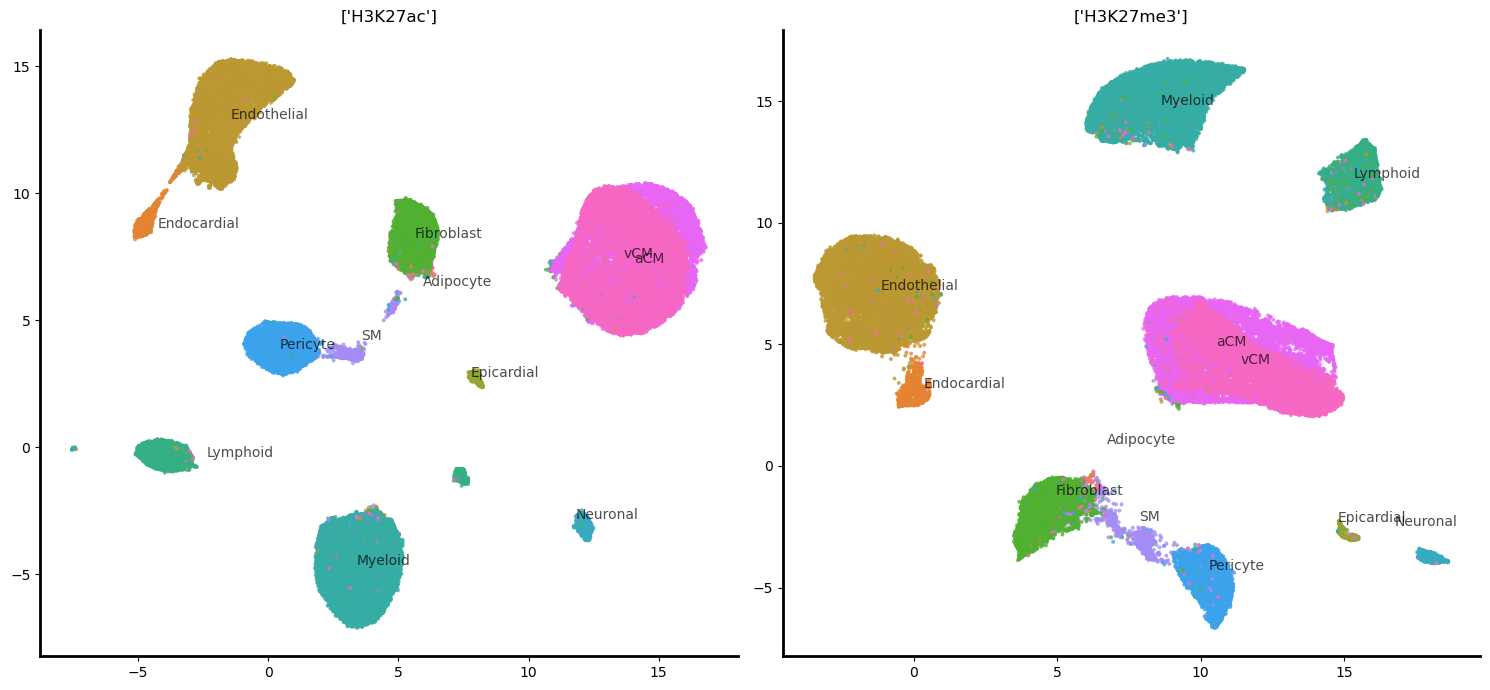

In [22]:
hhue = 'predicted.celltype'

fig, axes = plt.subplots(1, 2, figsize=(15, 7))
for i in range(len([k27ac_data, k27me3_data])):
    data = [k27ac_data, k27me3_data][i]
    ttarget = np.unique(data.obs['Target'])
    yi = data.obsm['X_umap']
    lmeta = data.obs

    ax = axes[i]
    sns.scatterplot(x=yi[:, 0], y=yi[:, 1], ax=ax, s=8, alpha=0.8, # palette = celltype_colors,
                    linewidth=0, hue=lmeta[hhue], legend = False)
    ax.set_title(ttarget)
    sns.despine()
    ax.spines['left'].set_linewidth(2) 
    ax.spines['bottom'].set_linewidth(2)
    
    ### manually label point
    representative_points = []
    for cluster in np.unique(lmeta[hhue]):
        cluster_indices = np.where(lmeta == cluster)[0]
        centroid = np.mean(yi[cluster_indices], axis=0)
        representative_points.append(centroid)

    for ii, label in enumerate(np.unique(lmeta[hhue])):
        ax.annotate(label, (representative_points[ii][0], representative_points[ii][1]), fontsize=10, alpha=0.7)


plt.tight_layout()

In [23]:
## save DNA objects
k27ac_data.obs = k27ac_data.obs.astype(str)
k27ac_data.write("FNIH_Heart_pool.H3K27ac.h5ad")
k27me3_data.obs = k27me3_data.obs.astype(str)
k27me3_data.write("FNIH_Heart_pool.H3K27me3.h5ad")

... storing 'n_fragment' as categorical
... storing 'frac_dup' as categorical
... storing 'frac_mito' as categorical
... storing 'doublet_probability' as categorical
... storing 'doublet_score_x' as categorical
... storing 'orig.ident' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'percent.mt' as categorical
... storing 'percent.ribo' as categorical
... storing 'RNA_snn_res.0.3' as categorical
... storing 'seurat_clusters' as categorical
... storing 'doublet_score_y' as categorical
... storing 'doublet_ident' as categorical
... storing 'DROPLET.TYPE' as categorical
... storing 'BEST.GUESS' as categorical
... storing 'NEXT.GUESS' as categorical
... storing 'rna' as categorical
... storing 'rna_bc' as categorical
... storing 'dna' as categorical
... storing 'library_info' as categorical
... storing 'Donor' as categorical
... storing 'Batch' as categorical
... storing 'Target' as categorical
... storing 'nCount_SCT' as categor

In [5]:
k27ac_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27ac.h5ad", backed = None)
k27me3_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27me3.h5ad", backed = None)

dmeta = pd.concat([k27ac_data.obs, k27me3_data.obs], axis = 0)

In [24]:
### Also export umap cood to save
pd.DataFrame(k27ac_data.obsm['X_umap'], index=k27ac_data.obs_names).to_csv("FNIH_Heart_pool.H3K27ac.umap.csv")
pd.DataFrame(k27me3_data.obsm['X_umap'], index=k27me3_data.obs_names).to_csv("FNIH_Heart_pool.H3K27me3.umap.csv")

### Calculation cell type trees using histone data

In [29]:
nrmeta = pd.read_csv('integration/CAREHF_Multiome_DPT_RNA_int.meta.csv', index_col=0)
nrmeta = nrmeta.loc[nrmeta['orig.ident'] == 'DPT']
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']

/tmp/ipykernel_4188860/2753830593.py:1: DtypeWarning: Columns (4,5,6,7,54,55,58,59,60,62,63,64,66,74,75,78,79,80,81,82,83,84,88,89,90,91,92,93,94,95,96,97,98,99,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  nrmeta = pd.read_csv('integration/CAREHF_Multiome_DPT_RNA_int.meta.csv', index_col=0)


In [43]:
print(len(nrmeta.loc[(nrmeta['integrated_majortype'] == 1) & (nrmeta['Target'] == 'H3K27ac')].index))
print(len(nrmeta.loc[(nrmeta['integrated_majortype'] == 1) & (nrmeta['Target'] == 'H3K27me3')].index))

67476
62167


In [38]:
cell1 = np.intersect1d(nrmeta.loc[(nrmeta['integrated_majortype'] == 1) & (nrmeta['Target'] == 'H3K27ac')].index, k27ac_data.obs_names)
cell2 = np.intersect1d(nrmeta.loc[(nrmeta['integrated_majortype'] == 1) & (nrmeta['Target'] == 'H3K27me3')].index, k27me3_data.obs_names)
print(len(cell1))
print(len(cell2))

67462
62138


In [41]:
tdata = k27ac_data[cell1,:]
rpm = snap.tl.aggregate_X(tdata, groupby = 'predicted.celltype')
rpm = pd.DataFrame(rpm.X.T, columns = rpm.obs_names, index = rpm.var_names)

tdata.obs['n_fragment'] = pd.to_numeric(tdata.obs['n_fragment'])
total_frag = tdata.obs.groupby('predicted.celltype')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.15kb.cpm.csv')
cpm[k27ac_data.var.selected].to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.var_15kb.cpm.csv')

/tmp/ipykernel_4188860/3795961885.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tdata.obs['n_fragment'] = pd.to_numeric(tdata.obs['n_fragment'])
/tmp/ipykernel_4188860/3795961885.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = tdata.obs.groupby('predicted.celltype')['n_fragment'].sum()


In [42]:
tdata = k27me3_data[cell2,:]
rpm = snap.tl.aggregate_X(tdata, groupby = 'predicted.celltype')
rpm = pd.DataFrame(rpm.X.T, columns = rpm.obs_names, index = rpm.var_names)

tdata.obs['n_fragment'] = pd.to_numeric(tdata.obs['n_fragment'])
total_frag = tdata.obs.groupby('predicted.celltype')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.15kb.cpm.csv')
cpm[k27me3_data.var.selected].to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.var_15kb.cpm.csv')

/tmp/ipykernel_4188860/1812342028.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tdata.obs['n_fragment'] = pd.to_numeric(tdata.obs['n_fragment'])
/tmp/ipykernel_4188860/1812342028.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = tdata.obs.groupby('predicted.celltype')['n_fragment'].sum()


In [114]:
### Find H3K27me3 marker regions!!! We dont need to test H3K27ac
import warnings
warnings.filterwarnings("ignore")

mregion = []
for f in np.unique(tdata.obs['predicted.celltype']):
    ### select variable features to test
    
    fcell = tdata.obs.loc[tdata.obs['predicted.celltype'] == f].index
    tmp = tdata[fcell,:]
    snap.pp.select_features(tmp, n_features = 100000, filter_lower_quantile=0.1,
                            blacklist="/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/hg38-blacklist.v2.bed")

    qfeatures = tmp.var.selected[tmp.var.selected].index
    rcell = []
    for i in np.unique(tdata.obs['predicted.celltype']):
        cts = tdata.obs.loc[tdata.obs['predicted.celltype'] == i].index
        if i != f and len(cts) > 500:
            cells = np.random.choice(cts, size=500, replace=False)
        else:
            cells = cts
            rcell.append(cells)      
    rcell = np.concatenate(rcell)
    fmarker = snap.tl.diff_test(tdata, fcell, rcell, features = qfeatures, 
                                direction='positive', 
                                min_log_fc=0.1, min_pct=0.1)
    if fmarker.shape[0] != 0:
        tmp = pd.DataFrame(fmarker, columns = fmarker.columns)
        tmp['celltype'] = f
        mregion.append(tmp)
        
# pd.concat(mregion, axis = 0).to_csv("FNIH_Heart_analysis/H3K27me3_15kb_snapatac2_LR_test.csv")

2025-03-17 21:00:45 - INFO - Selected 99033 features.
2025-03-17 21:00:46 - INFO - Input contains 99033 features, now perform filtering with 'min_log_fc = 0.1' and 'min_pct = 0.1' ...
2025-03-17 21:00:57 - WARNING - Zero feature left after filtering, perhaps 'min_log_fc' or 'min_pct' is too large
2025-03-17 21:00:58 - INFO - Selected 98950 features.
2025-03-17 21:00:59 - INFO - Input contains 98950 features, now perform filtering with 'min_log_fc = 0.1' and 'min_pct = 0.1' ...
2025-03-17 21:01:09 - WARNING - Zero feature left after filtering, perhaps 'min_log_fc' or 'min_pct' is too large


ValueError: No objects to concatenate

## Read and merge gene activity

In [10]:
ga_list = []
for f in dna:
    ga = snap.read('snapatac/' + f + '_gene_matrix_raw.h5ad', backed=None)
    tmp = pd.DataFrame(ga.X.T.toarray(), index=ga.var_names, columns=ga.obs_names)
    tmp.columns = f + ':' + tmp.columns
    ga_list.append(tmp)

ga_list = pd.concat(ga_list, axis=1)
ga_list.shape

(60606, 220043)

In [52]:
GA = anndata.AnnData(ga_list[dmeta.index].T)
GA.obs = dmeta
GA.write("FNIH_Heart_signal/FNIH_Heart_pool.GA.h5ad")

... storing 'n_fragment' as categorical
... storing 'frac_dup' as categorical
... storing 'doublet_probability' as categorical
... storing 'doublet_score_x' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'percent.mt' as categorical
... storing 'percent.ribo' as categorical
... storing 'RNA_snn_res.0.3' as categorical
... storing 'doublet_score_y' as categorical
... storing 'NEXT.GUESS' as categorical
... storing 'rna' as categorical
... storing 'rna_bc' as categorical
... storing 'dna' as categorical
... storing 'library_info' as categorical
... storing 'Target' as categorical
... storing 'nCount_SCT' as categorical
... storing 'nFeature_SCT' as categorical
... storing 'predicted.celltype_scores' as categorical
... storing 'predicted.cellsubtype_scores' as categorical
... storing 'atac_bc' as categorical
... storing 'leiden' as categorical


## Generate peaks matrix

In [ ]:
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']

In [3]:
k27ac_dts = snap.read_dataset("FNIH_Donor_pool.histone.h5ads")
k27ac_dts ### actually this is all histones

Unable to create stacked arrays for these keys: fragment_paired


AnnDataSet object with n_obs x n_vars = 220043 x 202081 backed at 'FNIH_Donor_pool.histone.h5ads'
contains 16 AnnData objects with keys: 'QY_2600', 'QY_2602', 'QY_2604', 'QY_2606', 'QY_2608', 'QY_2610', 'QY_2612', 'QY_2614', 'QY_2616', 'QY_2618', 'QY_2620', 'QY_2622', 'QY_2624', 'QY_2626', 'QY_2661', 'QY_2663'
    obs: 'sample'
    uns: 'AnnDataSet'

In [4]:
k27ac_peaks = snap.pp.make_peak_matrix(k27ac_dts, peak_file = '../10.conserved_peaks/parsePeak/FNIH_heart_H3K27ac.union.peak.bed',# file = "",
                                       min_frag_size=10, max_frag_size=5000)
k27ac_peaks

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


RuntimeError: neither 'fragment_single' nor 'fragment_paired' is present in the '.obsm'

In [12]:
k27ac_dts.close()

In [ ]:
### dont know why, works on other ways
### update 241001: we specify the counting stragety as "fragment" since for histone modification
### we focus more on the "region" where signal spans, instead of the Tn5 iinsertion events.
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.make_peak_matrix(data, peak_file = '../10.conserved_peaks/parsePeak/FNIH_heart_H3K27ac.union.peak.bed', 
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    peak_list.append(tmp)
    data.close()

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
import anndata as an
k27ac_peaks = an.concat(peak_list)
k27ac_peaks

In [ ]:
## Add metadata too
k27ac_peaks = k27ac_peaks[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]

k27ac_peaks.obs['chamber'] = nrmeta.loc[k27ac_peaks.obs_names]['chamber']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']
k27ac_peaks.obs['HF'] = nrmeta.loc[k27ac_peaks.obs_names]['condition']
k27ac_peaks.obs['disease'] = nrmeta.loc[k27ac_peaks.obs_names]['HF']
k27ac_peaks.obs['Gender'] = nrmeta.loc[k27ac_peaks.obs_names]['Gender']

In [59]:
k27ac_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.peaks.h5ad")

... storing 'Donor' as categorical
... storing 'chamber' as categorical
... storing 'HF' as categorical
... storing 'disease' as categorical
... storing 'Gender' as categorical


In [93]:
k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'predicted.celltype')
pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)

,Adipocyte,Endocardial,Endothelial,Epicardial,Fibroblast,Lymphoid,Myeloid,Neuronal,Pericyte,SM,aCM,vCM
chr1:9790-10789,15.0,102.0,837.0,26.0,515.0,367.0,1950.0,109.0,475.0,107.0,2387.0,1493.0
chr1:11807-12806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:13164-14163,0.0,1.0,8.0,0.0,2.0,1.0,4.0,0.0,1.0,0.0,33.0,22.0
chr1:14215-15214,0.0,1.0,5.0,1.0,4.0,0.0,7.0,0.0,1.0,0.0,29.0,15.0
chr1:15727-16726,0.0,1.0,13.0,0.0,9.0,3.0,21.0,2.0,5.0,5.0,41.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...
chrY:56762977-56763976,0.0,2.0,6.0,1.0,10.0,3.0,21.0,3.0,6.0,1.0,53.0,33.0
chrY:56764719-56765718,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrY:56766817-56767816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chrY:56768097-56769096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
# k27me3_peaks = snap.pp.make_peak_matrix(k27ac_dts, peak_file = '../10.conserved_peaks/parsePeak/FNIH_liver_H3K27me3.filteredNfixed.union.bed',# file = "",
#                                        min_frag_size=10, max_frag_size=5000)
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.make_peak_matrix(data, peak_file = '../10.conserved_peaks/parsePeak/FNIH_heart_H3K27me3.union.peak.bed', 
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    peak_list.append(tmp)
    data.close()
    
k27me3_peaks = an.concat(peak_list)
k27me3_peaks = k27me3_peaks[k27me3_data.obs_names,:]
k27me3_peaks.obs = k27me3_data.obs.loc[k27me3_peaks.obs_names]

k27me3_peaks.obs['chamber'] = nrmeta.loc[k27me3_peaks.obs_names]['chamber']
k27me3_peaks.obs['Donor'] = nrmeta.loc[k27me3_peaks.obs_names]['Donor']
k27me3_peaks.obs['HF'] = nrmeta.loc[k27me3_peaks.obs_names]['condition']
k27me3_peaks.obs['disease'] = nrmeta.loc[k27me3_peaks.obs_names]['HF']
k27me3_peaks.obs['Gender'] = nrmeta.loc[k27me3_peaks.obs_names]['Gender']

k27me3_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.peaks.h5ad")

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: Implic

## Aggregate by predicted celltype label

In [110]:
k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'predicted.celltype')
k27me3_rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'predicted.celltype')

In [111]:
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)
# k27ac_rpm.to_csv('FNIH_Heart_pool.H3K27ac.peaks.rpm.csv')

k27me3_rpm = pd.DataFrame(k27me3_rpm.X.T, index=k27me3_rpm.var_names, columns=k27me3_rpm.obs_names)
# k27me3_rpm.to_csv('FNIH_Heart_pool.H3K27me3.peaks.rpm.csv')

In [113]:
np.unique(k27ac_rpm.sum(axis=1) == 0, return_counts = True)

(array([False,  True]), array([416794,   1376]))

In [114]:
np.unique(k27me3_rpm.sum(axis=1) == 0, return_counts = True)

(array([False,  True]), array([361848,   3604]))

In [115]:
k27ac_peaks.obs['n_fragment'] = k27ac_data.obs['n_fragment'].cat.codes
total_frag = k27ac_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6

k27me3_peaks.obs['n_fragment'] = k27me3_data.obs['n_fragment'].cat.codes
total_frag = k27me3_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
k27me3_cpm = (k27me3_rpm / total_frag) * 1e6

k27ac_cpm.to_csv('FNIH_Heart_pool.H3K27ac.peaks.cpm.csv')
k27me3_cpm.to_csv('FNIH_Heart_pool.H3K27me3.peaks.cpm.csv')

/tmp/ipykernel_399377/1402318542.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27ac_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
/tmp/ipykernel_399377/1402318542.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27me3_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()


## Aggregate by predicted celltype label + Donor (for DE test)

In [167]:
k27ac_peaks.obs['chamber'] = nrmeta.loc[k27ac_peaks.obs_names]['chamber']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']

k27me3_peaks.obs['chamber'] = nrmeta.loc[k27me3_peaks.obs_names]['chamber']
k27me3_peaks.obs['Donor'] = nrmeta.loc[k27me3_peaks.obs_names]['Donor']

In [168]:
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + ":" + k27ac_peaks.obs['chamber'].astype("str") + ":" + k27ac_peaks.obs['Donor'].astype("str")
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + ":" + k27me3_peaks.obs['chamber'].astype("str") + ":" + k27me3_peaks.obs['Donor'].astype("str")

In [169]:
k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
k27me3_rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')

In [170]:
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)
k27me3_rpm = pd.DataFrame(k27me3_rpm.X.T, index=k27me3_rpm.var_names, columns=k27me3_rpm.obs_names)
k27ac_rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27ac.peaks.rpm.csv')
k27me3_rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27me3.peaks.rpm.csv')

In [129]:
total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6

# k27me3_peaks.obs['n_fragment'] = k27me3_data.obs['n_fragment'].cat.codes
total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()
k27me3_cpm = (k27me3_rpm / total_frag) * 1e6

k27ac_cpm.to_csv('FNIH_Heart_pool_celltype_donor.H3K27ac.peaks.cpm.csv')
k27me3_cpm.to_csv('FNIH_Heart_pool_celltype_donor.H3K27me3.peaks.cpm.csv')

## Genearate TSS matrix

In [179]:
qry_peaks = "/projects/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-arc-GRCh38-2020-A-2.0.0/regions/tss_1500bp.bed"
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.make_peak_matrix(data, peak_file = qry_peaks, 
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    
    ### is there dup var?
    rrm = tmp.var.index.duplicated()
    ttmp = tmp[:, ~rrm].copy()
    peak_list.append(ttmp)
    data.close()

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: Implic

In [219]:
k27me3_peaks = an.concat(peak_list)
k27me3_peaks = k27me3_peaks[k27me3_data.obs_names,:]
k27me3_peaks.obs = k27me3_data.obs.loc[k27me3_peaks.obs_names]
k27me3_peaks.obs['chamber'] = nrmeta.loc[k27me3_peaks.obs_names]['chamber']
k27me3_peaks.obs['Donor'] = nrmeta.loc[k27me3_peaks.obs_names]['Donor']

k27me3_peaks.write("FNIH_Heart_pool.H3K27me3.TSS.h5ad")

k27ac_peaks = an.concat(peak_list)
k27ac_peaks = k27ac_peaks[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]
k27ac_peaks.obs['chamber'] = nrmeta.loc[k27ac_peaks.obs_names]['chamber']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']

k27ac_peaks.write("FNIH_Heart_pool.H3K27ac.TSS.h5ad")

In [226]:
k27ac_peaks = an.concat(peak_list)
k27ac_peaks = k27ac_peaks[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]
k27ac_peaks.obs['chamber'] = nrmeta.loc[k27ac_peaks.obs_names]['chamber']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']

k27ac_peaks.write("FNIH_Heart_pool.H3K27ac.TSS.h5ad")

... storing 'Donor' as categorical
... storing 'chamber' as categorical


In [227]:
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + ":" + k27ac_peaks.obs['chamber'].astype("str") + ":" + k27ac_peaks.obs['Donor'].astype("str")

rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27ac.TSS.rpm.csv')

In [224]:
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + ":" + k27me3_peaks.obs['chamber'].astype("str") + ":" + k27me3_peaks.obs['Donor'].astype("str")

rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27me3.TSS.rpm.csv')

## Generate ATAC-peak based matrix

In [230]:
qry_peaks = "/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/reference/FNIH_peaks/Heart_UnionPeak.bed"
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.make_peak_matrix(data, peak_file = qry_peaks, 
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    
    ### is there dup var?
#     rrm = tmp.var.index.duplicated()
#     ttmp = tmp[:, ~rrm].copy()
    peak_list.append(tmp)
    data.close()

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: Implic

In [231]:
annpeak = an.concat(peak_list)
k27me3_peaks = annpeak[k27me3_data.obs_names,:]
k27me3_peaks.obs = k27me3_data.obs.loc[k27me3_peaks.obs_names]
k27me3_peaks.obs['chamber'] = nrmeta.loc[k27me3_peaks.obs_names]['chamber']
k27me3_peaks.obs['Donor'] = nrmeta.loc[k27me3_peaks.obs_names]['Donor']
k27me3_peaks.obs['HF'] = nrmeta.loc[k27me3_peaks.obs_names]['condition']
k27me3_peaks.obs['disease'] = nrmeta.loc[k27me3_peaks.obs_names]['HF']
k27me3_peaks.obs['Gender'] = nrmeta.loc[k27me3_peaks.obs_names]['Gender']

k27me3_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.h5ad")

k27ac_peaks = annpeak[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]
k27ac_peaks.obs['chamber'] = nrmeta.loc[k27ac_peaks.obs_names]['chamber']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']
k27ac_peaks.obs['HF'] = nrmeta.loc[k27ac_peaks.obs_names]['condition']
k27ac_peaks.obs['disease'] = nrmeta.loc[k27ac_peaks.obs_names]['HF']
k27ac_peaks.obs['Gender'] = nrmeta.loc[k27ac_peaks.obs_names]['Gender']

k27ac_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.h5ad")

... storing 'Donor' as categorical
... storing 'chamber' as categorical
... storing 'Donor' as categorical
... storing 'chamber' as categorical


In [3]:
k27ac_peaks = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.h5ad", backed = None)
k27me3_peaks = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.h5ad", backed = None)

In [6]:
np.unique(k27ac_peaks.obs['predicted.celltype'], return_counts=True)

(array(['Adipocyte', 'Endocardial', 'Endothelial', 'Epicardial',
        'Fibroblast', 'Lymphoid', 'Myeloid', 'Neuronal', 'Pericyte', 'SM',
        'aCM', 'vCM'], dtype=object),
 array([  123,  1132, 13451,   585,  5750,  2890, 12591,   982,  6436,
         1305,  9820, 13260]))

In [7]:
np.unique(k27me3_peaks.obs['predicted.celltype'], return_counts=True)

(array(['Adipocyte', 'Endocardial', 'Endothelial', 'Epicardial',
        'Fibroblast', 'Lymphoid', 'Myeloid', 'Neuronal', 'Pericyte', 'SM',
        'aCM', 'vCM'], dtype=object),
 array([  122,  1146, 14447,   537,  6834,  3064, 10697,   903,  4744,
         1307,  8452, 10675]))

In [232]:
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + ":" + k27ac_peaks.obs['chamber'].astype("str") + ":" + k27ac_peaks.obs['Donor'].astype("str")

rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27ac.HeartUnionPeak.rpm.csv')

In [233]:
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + ":" + k27me3_peaks.obs['chamber'].astype("str") + ":" + k27me3_peaks.obs['Donor'].astype("str")

rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv('FNIH_Heart_pool_chamber_celltype_donor.H3K27me3.HeartUnionPeak.rpm.csv')

In [50]:
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") 
k27ac_peaks.obs['n_fragment'] = pd.to_numeric(k27ac_peaks.obs['n_fragment'])
rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv')

k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str")
k27me3_peaks.obs['n_fragment'] = pd.to_numeric(k27me3_peaks.obs['n_fragment'])
rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.cpm.csv')

In [5]:
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)
idx = pd.Index(dinfo['Patient.ID']).get_indexer(k27me3_peaks.obs['Donor'])

k27me3_peaks.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + "-" + k27me3_peaks.obs['HF'].astype("str")

idx = pd.Index(dinfo['Patient.ID']).get_indexer(k27ac_peaks.obs['Donor'])
k27ac_peaks.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + "-" + k27ac_peaks.obs['HF'].astype("str")

In [4]:
k27ac_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27ac.h5ad", backed = None)
k27me3_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27me3.h5ad", backed = None)

In [14]:
rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
k27ac_peaks.obs['n_fragment'] = pd.to_numeric(k27ac_data.obs['n_fragment'])
total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.disease.HeartUnionPeak.cpm.csv')

rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
k27me3_peaks.obs['n_fragment'] = pd.to_numeric(k27me3_data.obs['n_fragment'])
total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.disease.HeartUnionPeak.cpm.csv')

/tmp/ipykernel_561264/1362029716.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
/tmp/ipykernel_561264/1362029716.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()


In [36]:
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27me3_data.obs['Donor'] = nrmeta.loc[k27me3_data.obs_names]['Donor']
k27me3_data.obs['condition'] = k27me3_data.obs['predicted.celltype'].astype("str") + ":" + k27me3_data.obs['Donor'].astype("str")
rpm = snap.tl.aggregate_X(k27me3_data, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.15kb.csv")

rpm.shape

(191678, 347)

In [8]:
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27me3_data.obs['HF'] = nrmeta.loc[k27me3_data.obs_names]['condition']
k27me3_data.obs['condition'] = k27me3_data.obs['predicted.celltype'].astype("str") + ":" + k27me3_data.obs['HF'].astype("str")
rpm = snap.tl.aggregate_X(k27me3_data, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.shape

(191678, 24)

In [11]:
k27me3_data.obs['n_fragment'] = pd.to_numeric(k27me3_data.obs['n_fragment'])
total_frag = k27me3_data.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv("FNIH_Heart_signal/FNIH_Heart_pool.celltype_disease.H3K27me3.15kb.cpm.csv")

In [8]:
# k27ac_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.h5ad")
# k27me3_peaks.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.h5ad")

... storing 'HF' as categorical
... storing 'condition' as categorical
... storing 'HF' as categorical
... storing 'condition' as categorical


### Subtype level

In [28]:
# meta = pd.read_csv("../../87.FNIH_DHC_IGM_240925/05.R/integration/All_data.int.csv", index_col=0)
meta = pd.read_csv("../../81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.meta.csv", index_col = 0)
tmeta = meta.loc[(meta['orig.ident'] == 'DPT') & (meta['Target'] == 'H3K27ac') & (meta['integrated_subtype'] == 1)]
tmeta.index = tmeta.dna + ":" + tmeta.dna_bc

/tmp/ipykernel_2961651/1907370631.py:2: DtypeWarning: Columns (4,5,6,7,54,55,58,59,60,62,63,64,66,74,75,78,79,80,81,82,83,84,88,89,90,91,92,93,94,95,96,97,98,99,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv("../../81.FNIH_DPT_IGM_240827/05.R/integration/CAREHF_Multiome_DPT_RNA_int.meta.csv", index_col = 0)


In [14]:
tmp = k27ac_peaks[np.intersect1d(k27ac_peaks.obs_names, tmeta.index),:]
tmp.obs['subtype'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']
tmp.obs['Donor'] = tmeta.loc[tmp.obs_names]['Donor']
tmp.obs['condition'] = tmp.obs['subtype'].astype("str") + ":" + tmp.obs['Donor'].astype("str")

tmp.obs['n_fragment'] = pd.to_numeric(tmp.obs['n_fragment'])
rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv("FNIH_Heart_signal/FNIH_Heart_pool_cellsubtype_donor.H3K27ac.HeartUnionPeak.rpm.csv")

/tmp/ipykernel_2961651/2965765999.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['subtype'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']


In [69]:
tmp = k27ac_peaks[np.intersect1d(k27ac_peaks.obs_names, tmeta.index),:]
tmp.obs['condition'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']
tmp.obs['n_fragment'] = tmp.obs['n_fragment'].cat.codes
rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cellsubtype.cpm.csv')

/tmp/ipykernel_2496444/2947664978.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['condition'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']


In [15]:
tmeta = meta.loc[(meta['orig.ident'] == 'DPT') & (meta['Target'] == 'H3K27me3') & (meta['integrated_subtype'] == 1)]
tmeta.index = tmeta.dna + ":" + tmeta.dna_bc

tmp = k27me3_peaks[np.intersect1d(k27me3_peaks.obs_names, tmeta.index),:]
tmp.obs['subtype'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']
tmp.obs['Donor'] = tmeta.loc[tmp.obs_names]['Donor']
tmp.obs['condition'] = tmp.obs['subtype'].astype("str") + ":" + tmp.obs['Donor'].astype("str")

tmp.obs['n_fragment'] = pd.to_numeric(tmp.obs['n_fragment'])
rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv("FNIH_Heart_signal/FNIH_Heart_pool_cellsubtype_donor.H3K27me3.HeartUnionPeak.rpm.csv")

/tmp/ipykernel_2961651/698176392.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['subtype'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']


In [70]:
tmp = k27me3_peaks[np.intersect1d(k27me3_peaks.obs_names, tmeta.index),:]
tmp.obs['condition'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']
tmp.obs['n_fragment'] = tmp.obs['n_fragment'].cat.codes
rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_pool.H3K27me3.HeartUnionPeak.cellsubtype.cpm.csv')

/tmp/ipykernel_2496444/3878854169.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['condition'] = tmeta.loc[tmp.obs_names]['nn2.cell_subtype']


### Celltype by donor

In [30]:
k27ac_peaks = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.peaks.h5ad", backed=None)
tmp = k27ac_peaks[np.intersect1d(k27ac_peaks.obs_names, tmeta.index),:]
tmp.obs['nn2.celltype'] = tmeta.loc[tmp.obs_names]['nn2.celltype']
tmp.obs['Donor'] = tmeta.loc[tmp.obs_names]['Donor']
tmp.obs['condition'] = tmp.obs['nn2.celltype'].astype("str") + ":" + tmp.obs['Donor'].astype("str")

rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
rpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool_celltype_donor.H3K27ac.rpm.csv')

rpm.head()

/tmp/ipykernel_2961651/1620451170.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['nn2.celltype'] = tmeta.loc[tmp.obs_names]['nn2.celltype']


,Adipocyte:D35,Adipocyte:D36,Adipocyte:D37,Adipocyte:D38,Adipocyte:D40,Adipocyte:D51,Adipocyte:D52,Adipocyte:D53,Adipocyte:D55,Adipocyte:DTX027,...,vCM:DTX087,vCM:DTX088,vCM:DTX089,vCM:DTX091,vCM:DTX093,vCM:DTX096,vCM:DTX097,vCM:DTX105,vCM:DTX114,vCM:DTX119
chr1:9790-10789,1.0,4.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,...,20.0,16.0,80.0,27.0,8.0,10.0,6.0,39.0,27.0,12.0
chr1:11807-12806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
chr1:13164-14163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
chr1:14215-15214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
chr1:15727-16726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0


## Generate tile matrix for hic analysis (10k / 100k)

In [8]:
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.add_tile_matrix(data, bin_size=10000, inplace = False,
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    peak_list.append(tmp)
    data.close()

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:

In [9]:
import anndata as an
bmtx = an.concat(peak_list)
bmtx

AnnData object with n_obs × n_vars = 220043 × 303114
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score', 'leiden'

In [11]:
## Add metadata too
k27ac_peaks = bmtx[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]
k27ac_peaks.write("FNIH_Heart_pool.H3K27ac.10kb.h5ad")

k27ac_peaks

AnnData object with n_obs × n_vars = 68325 × 303114
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'RNA_snn_res.0.3', 'seurat_clusters', 'doublet_score_y', 'doublet_ident', 'DROPLET.TYPE', 'BEST.GUESS', 'NEXT.GUESS', 'rna', 'rna_bc', 'dna', 'library_info', 'dna_bc', 'Donor', 'Batch', 'Target', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'predicted.celltype', 'predicted.celltype_scores', 'predicted.cellsubtype', 'predicted.cellsubtype_scores', 'atac_bc', 'leiden'

In [12]:
k27me3_peaks = bmtx[k27me3_data.obs_names,:]
k27me3_peaks.obs = k27me3_data.obs.loc[k27me3_peaks.obs_names]
k27me3_peaks.write("FNIH_Heart_pool.H3K27me3.10kb.h5ad")

k27me3_peaks

AnnData object with n_obs × n_vars = 62928 × 303114
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'RNA_snn_res.0.3', 'seurat_clusters', 'doublet_score_y', 'doublet_ident', 'DROPLET.TYPE', 'BEST.GUESS', 'NEXT.GUESS', 'rna', 'rna_bc', 'dna', 'library_info', 'dna_bc', 'Donor', 'Batch', 'Target', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'predicted.celltype', 'predicted.celltype_scores', 'predicted.cellsubtype', 'predicted.cellsubtype_scores', 'atac_bc', 'leiden'

In [21]:
### 100kb regions
k27me3_peaks = snap.read('FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.100kb.h5ad', backed = None)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27me3_peaks.obs['HF'] = nrmeta.loc[k27me3_peaks.obs_names]['condition']
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + ":" + k27me3_peaks.obs['HF'].astype("str")

k27me3_rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
k27me3_rpm = pd.DataFrame(k27me3_rpm.X.T, index=k27me3_rpm.var_names, columns=k27me3_rpm.obs_names)
k27me3_peaks.obs['n_fragment'] = pd.to_numeric(k27me3_peaks.obs['n_fragment'])
total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()
k27me3_cpm = (k27me3_rpm / total_frag) * 1e6
k27me3_cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool_celltype_disease.H3K27me3.100kb.cpm.csv')

In [3]:
k27ac_peaks = snap.read('FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.100kb.h5ad', backed = None)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27ac_peaks.obs['HF'] = nrmeta.loc[k27ac_peaks.obs_names]['condition']
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + ":" + k27ac_peaks.obs['HF'].astype("str")

k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)
k27ac_peaks.obs['n_fragment'] = pd.to_numeric(k27ac_peaks.obs['n_fragment'])
total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6
k27ac_cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool_celltype_disease.H3K27ac.100kb.cpm.csv')

In [9]:
### 10kb regions
k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'predicted.celltype')
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)

k27me3_rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'predicted.celltype')
k27me3_rpm = pd.DataFrame(k27me3_rpm.X.T, index=k27me3_rpm.var_names, columns=k27me3_rpm.obs_names)

k27ac_peaks.obs['n_fragment'] = pd.to_numeric(k27ac_peaks.obs['n_fragment'])
total_frag = k27ac_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6

k27me3_peaks.obs['n_fragment'] = pd.to_numeric(k27me3_peaks.obs['n_fragment'])
total_frag = k27me3_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
k27me3_cpm = (k27me3_rpm / total_frag) * 1e6

k27ac_cpm.to_csv('FNIH_Heart_pool.H3K27ac.10kb.cpm.csv')
k27me3_cpm.to_csv('FNIH_Heart_pool.H3K27me3.10kb.cpm.csv')

/tmp/ipykernel_681108/1303903627.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27ac_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()
/tmp/ipykernel_681108/1303903627.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_frag = k27me3_peaks.obs.groupby('predicted.celltype')['n_fragment'].sum()


In [22]:
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']
k27me3_peaks.obs['Donor'] = nrmeta.loc[k27me3_peaks.obs_names]['Donor']

idx = pd.Index(dinfo['Patient.ID']).get_indexer(k27ac_peaks.obs['Donor'])
k27ac_peaks.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
idx = pd.Index(dinfo['Patient.ID']).get_indexer(k27me3_peaks.obs['Donor'])
k27me3_peaks.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])

In [26]:
k27ac_peaks.obs['condition'] = k27ac_peaks.obs['predicted.celltype'].astype("str") + ":" + k27ac_peaks.obs['HF'].astype("str")
k27me3_peaks.obs['condition'] = k27me3_peaks.obs['predicted.celltype'].astype("str") + ":" + k27me3_peaks.obs['HF'].astype("str")

k27ac_rpm = snap.tl.aggregate_X(k27ac_peaks, groupby = 'condition')
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, index=k27ac_rpm.var_names, columns=k27ac_rpm.obs_names)

k27me3_rpm = snap.tl.aggregate_X(k27me3_peaks, groupby = 'condition')
k27me3_rpm = pd.DataFrame(k27me3_rpm.X.T, index=k27me3_rpm.var_names, columns=k27me3_rpm.obs_names)

total_frag = k27ac_peaks.obs.groupby('condition')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6

total_frag = k27me3_peaks.obs.groupby('condition')['n_fragment'].sum()
k27me3_cpm = (k27me3_rpm / total_frag) * 1e6

k27ac_cpm.to_csv('FNIH_Heart_pool.H3K27ac.disease_celltype.10kb.cpm.csv')
k27me3_cpm.to_csv('FNIH_Heart_pool.H3K27me3.disease_celltype.10kb.cpm.csv')

## Calculate for ATAC shuffled peaks

In [76]:
shuf_peaks = pd.read_csv('../10.conserved_peaks/peak2cnt/shufflePeak/all_shuffle.bed', sep = '\t', names = ['chrom', 'start', 'end', 'width', 'strand', 'name'])
shuf_peaks['range'] = shuf_peaks.chrom + ":" + shuf_peaks.start.astype(str) + "-" + shuf_peaks.end.astype(str)
shuf_peaks.head()

,chrom,start,end,width,strand,name,range
0,chr14,82314125,82314425,301,*,Adipocyte_UnifiedFiltVariable_shuf_1,chr14:82314125-82314425
1,chr4,180566465,180566765,301,*,Adipocyte_UnifiedFiltVariable_shuf_2,chr4:180566465-180566765
2,chrX,117732382,117732682,301,*,Adipocyte_UnifiedFiltVariable_shuf_3,chrX:117732382-117732682
3,chr7,99836153,99836453,301,*,Adipocyte_UnifiedFiltVariable_shuf_4,chr7:99836153-99836453
4,chr6,107876617,107876917,301,*,Adipocyte_UnifiedFiltVariable_shuf_5,chr6:107876617-107876917


In [64]:
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.make_peak_matrix(data, peak_file = '../10.conserved_peaks/peak2cnt/shufflePeak/all_shuffle.bed', 
                                   min_frag_size=10, max_frag_size=5000, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    
    ### is there dup var?
    rrm = tmp.var.index.duplicated()
    ttmp = tmp[:, ~rrm].copy()
    peak_list.append(ttmp)
    data.close()
    
allpeaks = an.concat(peak_list)
k27ac_peaks = allpeaks[k27ac_data.obs_names,:]
k27ac_peaks.obs = k27ac_data.obs.loc[k27ac_peaks.obs_names]

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:183: Implic

In [92]:
meta = k27ac_data.obs
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)
nrmeta = pd.read_csv('FNIH_Heart_cluster/FNIH_Heart_pool_DPT_SNG_SoupX_reference_mapping_filtered.meta.xls', index_col=0, sep = '\t')
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']
k27ac_peaks.obs['Donor'] = nrmeta.loc[k27ac_peaks.obs_names]['Donor']
# k27ac_peaks.obs['n_fragment'] = k27ac_peaks.obs['n_fragment'].cat.codes

In [119]:
k27ac_peaks.write("../10.conserved_peaks/peak2cnt/shufflePeak/FNIH_Heart_pool.H3K27ac.all_shuffle.h5ad")

... storing 'Donor' as categorical


In [121]:
import re
celltype = [f.split("_")[0] for f in os.listdir("/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/10.conserved_peaks/peak2cnt/shufflePeak") if f.endswith('_UnifiedFiltVariable_shuf.bed')]
for fname in celltype:
    var_id = [ff for ff in shuf_peaks['name'] if ff.split("_")[0] in fname]
    var_name = shuf_peaks.loc[shuf_peaks['name'].isin(var_id)]['range']
    k27ac_cells = meta.loc[(meta['Target'] == 'H3K27ac') & (meta['predicted.celltype'] == fname)].index
    tmp = k27ac_peaks[k27ac_cells, var_name]
    tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
    idx = pd.Index(dinfo['Patient.ID']).get_indexer(tmp.obs['Donor'])
    tmp.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
    tmp.obs['condition'] = tmp.obs['predicted.celltype'].astype("str") + "_" + tmp.obs['HF'].astype("str")
    k27ac_rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
    k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, columns = k27ac_rpm.obs_names, index = k27ac_rpm.var_names)
    total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
    k27ac_cpm = (k27ac_rpm / total_frag) * 1e6
    k27ac_cpm.to_csv('/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/10.conserved_peaks/peak2cnt/H3K27ac/' + fname + '_H3K27ac_shuf.cpm.csv')

/tmp/ipykernel_2005032/3342923700.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/3342923700.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/3342923700.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/3342923700.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. T

In [131]:
for fname in celltype:
    var_id = [ff for ff in shuf_peaks['name'] if ff.split("_")[0] in fname]
    var_name = shuf_peaks.loc[shuf_peaks['name'].isin(var_id)]['range']
    k27ac_cells = meta.loc[(meta['Target'] == 'H3K27ac') & (meta['predicted.celltype'] == fname)].index
    tmp = k27ac_peaks[k27ac_cells, var_name]
    tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
    idx = pd.Index(dinfo['Patient.ID']).get_indexer(tmp.obs['Donor'])
    tmp.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
    tmp.obs['condition'] = tmp.obs['predicted.celltype'].astype("str") #+ "_" + tmp.obs['HF'].astype("str")
    k27ac_rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
    k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, columns = k27ac_rpm.obs_names, index = k27ac_rpm.var_names)
    total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
    k27ac_cpm = (k27ac_rpm / total_frag) * 1e6
    k27ac_cpm.to_csv('/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/10.conserved_peaks/peak2cnt/H3K27ac/' + fname + '_H3K27ac_shuf.cpm.csv')

/tmp/ipykernel_2005032/772877569.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/772877569.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/772877569.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/tmp/ipykernel_2005032/772877569.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tmp.obs['n_fragment'] = meta.loc[tmp.obs_names]['n_fragment'].cat.codes
/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To ma

In [138]:
test = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.peaks.h5ad")
test

AnnData object with n_obs x n_vars = 68325 x 418170 backed at 'FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.peaks.h5ad'
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'doublet_probability', 'doublet_score_x', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'RNA_snn_res.0.3', 'seurat_clusters', 'doublet_score_y', 'doublet_ident', 'DROPLET.TYPE', 'BEST.GUESS', 'NEXT.GUESS', 'rna', 'rna_bc', 'dna', 'library_info', 'dna_bc', 'Donor', 'Batch', 'Target', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.1', 'predicted.celltype', 'predicted.celltype_scores', 'predicted.cellsubtype', 'predicted.cellsubtype_scores', 'atac_bc', 'leiden'

In [123]:
# k27ac_peaks.obs['condition'] = atac.obs['cell.sub_types'].astype("str") 
# k27ac_peaks.obs['n_fragment'] = k27ac_peaks.obs['n_fragment'].cat.codes
# rpm = snap.tl.aggregate_X(atac, groupby = 'cell.sub_types')
# rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = atac.obs.groupby('cell.sub_types')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.ATAC.cellsubtype.cpm.csv')

### Diff test for ATAC peaks

In [70]:
atac = snap.read("../reference/ATAC_processed.h5ad")
peak_matrix = snap.pp.make_peak_matrix(atac, counting_strategy = 'fragment',
                                       peak_file="../reference/FNIH_peaks/Heart_UnionPeak.bed",  
                                       max_frag_size = 5000, min_frag_size = 10)
peak_matrix

/home/y2xie/miniconda3/envs/seurat/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1575608 × 285873
    obs: 'n_fragment', 'frac_dup', 'frac_mito'

In [98]:
ameta = pd.read_csv("../reference/LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.curated.peaks.meta.txt", sep = '\t')

peak_matrix = peak_matrix[ameta.index,:]
peak_matrix.obs[ameta.columns] = ameta.loc[peak_matrix.obs_names]
peak_matrix.write("../reference/ATAC_processed_peaks.h5ad")

atac.close()

... storing 'orig.ident' as categorical
... storing 'library' as categorical
... storing 'donor' as categorical
... storing 'chamber' as categorical
... storing 'condition' as categorical
... storing 'disease_status_major' as categorical
... storing 'disease_status_sub' as categorical
... storing 'diabetes_status' as categorical
... storing 'sex' as categorical
... storing 'sil.qc' as categorical
... storing 'cluster_sil.qc' as categorical
... storing 'cell.major_types' as categorical
... storing 'cell.sub_types' as categorical
... storing 'cell.sub_types_disease' as categorical
... storing 'barcode' as categorical
... storing 'atac_barcode' as categorical
... storing 'chamber_major' as categorical
... storing 'cell.sub_types_LUCA' as categorical
... storing 'cell.sub_types_chamber' as categorical
... storing 'cell.major_types_chamber' as categorical


In [9]:
atac = snap.read("../reference/ATAC_processed_peaks.h5ad", backed = None)
atac

AnnData object with n_obs × n_vars = 329255 × 285873
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'wsnn_res.0.25', 'library', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'a

In [10]:
atac.obs['condition'] = atac.obs['donor'].astype("str")
atac.obs['n_fragment'] = pd.to_numeric(atac.obs['n_fragment'])
rpm = snap.tl.aggregate_X(atac, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = atac.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.ATAC.donor.cpm.csv')

In [20]:
atac.obs['condition'] = atac.obs['donor'].astype("str") + "_" + atac.obs['cell.major_types'].astype("str") + "_" + atac.obs['disease_status_major'].astype("str") 
rpm = snap.tl.aggregate_X(atac, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = atac.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.ATAC.donor_celltype_HF.cpm.csv')

In [23]:
atac.obs['condition'] = atac.obs['cell.major_types'].astype("str") + "_" + atac.obs['chamber'].astype("str") + "_" + atac.obs['disease_status_major'].astype("str") 
rpm = snap.tl.aggregate_X(atac, groupby = 'condition')
rpm = pd.DataFrame(rpm.X.T, index=rpm.var_names, columns=rpm.obs_names)
total_frag = atac.obs.groupby('condition')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.ATAC.chamber_celltype_HF.cpm.csv')

In [108]:
import warnings
warnings.filterwarnings("ignore")

mregion = []
for f in np.unique(ameta['cell.major_types']):
    fcell = ameta.loc[ameta['cell.major_types'] == f].index
    rcell = []
    for i in np.unique(ameta['cell.major_types']):
        if i != f:
            cells = np.random.choice(ameta.loc[ameta['cell.major_types'] == i].index, size=500, replace=False)
            rcell.append(cells)
            
    rcell = np.concatenate(rcell)
#     rcell = ameta.loc[ameta.cluster != f]['barcode']
    ffeatures = pd.read_csv(f"../reference/FNIH_peaks/{f}_UnifiedFiltVariable.bed", sep ="\t", names = ['chrom', 'start', 'end','width', 'strand'])
    ffeatures = ffeatures.chrom + ":" + ffeatures.start.astype(str) + "-" + ffeatures.end.astype(str)
    fmarker = snap.tl.diff_test(peak_matrix, fcell, rcell, features = ffeatures, 
                                # covariates = ['library', 'sex'], ### This is what Elie and Luca suggests
                                direction='positive', 
                                min_log_fc=0.25, min_pct=0.05)
    tmp = pd.DataFrame(fmarker, columns = fmarker.columns)
    tmp['celltype'] = f
    mregion.append(tmp)

2024-12-01 22:21:41 - INFO - Input contains 35501 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2024-12-01 22:22:02 - INFO - Testing 4999 features ...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [07:32<00:00, 11.04it/s]
2024-12-01 22:29:39 - INFO - Input contains 62275 features, now perform filtering with 'min_log_fc = 0.25' and 'min_pct = 0.05' ...
2024-12-01 22:30:16 - INFO - Testing 3922 features ...
 47%|██████████████████████████████████████████████████████████████████████████▊                                                                                     | 1833/3922 [04:44<02:42, 12.84it/s]

In [113]:
pd.concat(mregion, axis = 0).to_csv("../reference/FNIH_peaks/snapatac2_LR_test.csv")

### Generate 25kb bins for insulation analysis

In [150]:
peak_list = []
for sample, f in zip(dna, file_dna):
    data = snap.read("snapatac/" + f)
    tmp = snap.pp.add_tile_matrix(data, bin_size = 25000, max_frag_size = 5000, min_frag_size = 10, 
                                   inplace = False, counting_strategy = 'fragment')
    tmp.obs_names = sample + ":" + tmp.obs_names
    peak_list.append(tmp)
    data.close()

In [189]:
import anndata as an
# bin25k = an.concat(peak_list)
tmp = bin25k[k27ac_peaks.obs_names,:]
tmp.obs = k27ac_peaks.obs.loc[tmp.obs_names]
tmp.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.25kb.h5ad")

tmp = bin25k[k27me3_peaks.obs_names,:]
tmp.obs = k27me3_peaks.obs.loc[tmp.obs_names]
tmp.write("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.25kb.h5ad")

In [51]:
dinfo = pd.read_csv('../reference/CAREHF_FNIH_donor.simple.info', sep = '\t', index_col=0)

tmp = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.25kb.h5ad", backed=None)
idx = pd.Index(dinfo['Patient.ID']).get_indexer(tmp.obs['Donor'])
tmp.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
tmp.obs['condition'] = tmp.obs['predicted.celltype'].astype("str") + "_" + tmp.obs['HF'].astype("str")
tmp.obs['n_fragment'] = pd.to_numeric(tmp.obs.loc[tmp.obs_names]['n_fragment'])

k27ac_rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, columns = k27ac_rpm.obs_names, index = k27ac_rpm.var_names)
total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6
k27ac_cpm.to_csv('/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/05.R/FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.25kb.cpm.csv')

In [52]:
tmp = snap.read("FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.25kb.h5ad", backed=None)
idx = pd.Index(dinfo['Patient.ID']).get_indexer(tmp.obs['Donor'])
tmp.obs['HF'] = np.array(dinfo.iloc[idx]['condition'])
tmp.obs['condition'] = tmp.obs['predicted.celltype'].astype("str") + "_" + tmp.obs['HF'].astype("str")

k27ac_rpm = snap.tl.aggregate_X(tmp, groupby = 'condition')
k27ac_rpm = pd.DataFrame(k27ac_rpm.X.T, columns = k27ac_rpm.obs_names, index = k27ac_rpm.var_names)

tmp.obs['n_fragment'] = pd.to_numeric(tmp.obs.loc[tmp.obs_names]['n_fragment'])
total_frag = tmp.obs.groupby('condition')['n_fragment'].sum()
k27ac_cpm = (k27ac_rpm / total_frag) * 1e6
k27ac_cpm.to_csv('/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/05.R/FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.25kb.cpm.csv')

## Process CAREHF ATAC data to get 15kb matrix

In [ ]:
libs = [f.split("__")[0] for f in os.listdir("/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/reference/CAREHF/fragment/fragment/") if f.endswith('__fragments.tsv.gz')]
for lib in libs:
    data = snap.pp.import_data(f"../reference/CAREHF/fragment/fragment/{lib}__fragments.tsv.gz",
                               sorted_by_barcode = False,
                               file = f"../reference/CAREHF/fragment/snapatac2/{lib}_processed.h5ad",
                               chrom_sizes = snap.genome.hg38)
    snap.pp.add_tile_matrix(data, bin_size = 15000, max_frag_size = 5000, min_frag_size = 10)
    data.close()

In [68]:
### Filter valid ATAC files
meta = pd.read_csv("integration/All_data_int_metadata.file.txt", sep = '\t')
blist = []
for lib in libs:
    tdata = snap.read(f'../reference/CAREHF/fragment/snapatac2/{lib}_processed.filt.h5ad', backed = None)
    data = snap.read(f'../reference/CAREHF/fragment/snapatac2/{lib}_processed.h5ad', backed = None)
    data.obs['bc'] = f'{lib}:' + data.obs_names
    validc = np.intersect1d(data.obs.bc, meta[meta.index.str.contains(lib, regex=True)].index)
    tdata = data[data.obs.bc.isin(validc),:]
    tdata.write(f'../reference/CAREHF/fragment/snapatac2/{lib}_processed.filt.h5ad')
    blist.append(tdata)

import anndata as an
carehf = an.concat(blist)
carehf.write("../reference/CAREHF_ATAC_processed_valid.h5ad")

carehf

View of AnnData object with n_obs × n_vars = 245534 × 202081
    obs: 'n_fragment', 'frac_dup', 'frac_mito', 'bc'
    obsm: 'fragment_paired'

In [90]:
carehf.obs['donor'] = np.array(meta.loc[carehf.obs['bc'], 'DONOR'])
rpm = snap.tl.aggregate_X(carehf, groupby = 'donor')
rpm = pd.DataFrame(rpm.X.T, columns = rpm.obs_names, index = rpm.var_names)

carehf.obs['n_fragment'] = pd.to_numeric(carehf.obs['n_fragment'])
total_frag = carehf.obs.groupby('donor')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/CAREHF_Heart_pool.ATAC.donor.15kb.cpm.csv')

In [71]:
## Also processed FNIH ATAC
tdata = snap.read("../reference/FNIH_ATAC_processed_valid.h5ad", backed = None)
rpm = snap.tl.aggregate_X(tdata, groupby = 'donor')
rpm = pd.DataFrame(rpm.X.T, columns = rpm.obs_names, index = rpm.var_names)

tdata.obs['n_fragment'] = pd.to_numeric(tdata.obs['n_fragment'])
total_frag = tdata.obs.groupby('donor')['n_fragment'].sum()
cpm = (rpm / total_frag) * 1e6
cpm.to_csv('FNIH_Heart_signal/FNIH_Heart_pool.ATAC.donor.15kb.cpm.csv')

245534

In [9]:
meta

NameError: name 'meta' is not defined

## Output clean object for upload

In [35]:
k27ac_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27ac.h5ad", backed = None)
k27me3_data = snap.read("FNIH_Heart_cluster/FNIH_Heart_pool.H3K27me3.h5ad", backed = None)
nrmeta = pd.read_csv('integration/CAREHF_Multiome_DPT_RNA_int.meta.csv', index_col=0)
nrmeta = nrmeta.loc[(nrmeta['orig.ident'] == 'DPT') & (nrmeta['integrated_majortype'] == 1)]
nrmeta.index = nrmeta['dna'] + ":" + nrmeta['dna_bc']

/tmp/ipykernel_1353931/3739330507.py:3: DtypeWarning: Columns (4,5,6,7,54,55,58,59,60,62,63,64,66,74,75,78,79,80,81,82,83,84,88,89,90,91,92,93,94,95,96,97,98,99,101,103) have mixed types. Specify dtype option on import or set low_memory=False.
  nrmeta = pd.read_csv('integration/CAREHF_Multiome_DPT_RNA_int.meta.csv', index_col=0)


In [42]:
valid_col = ['n_fragment', 'frac_dup', 'rna', 'rna_bc', 'dna', 'dna_bc', 'Donor', 'Target']
valid_col2 = ['chamber', 'Age', 'Gender', 'HF', 'Diabetes', 'condition', 
              'nn2.celltype', 'integrated_majortype', 'nn2.cell_subtype','integrated_subtype']

In [54]:
qcell1 = np.intersect1d(nrmeta.loc[nrmeta['Target'] == 'H3K27ac'].index, k27ac_data.obs_names)
k27ac_data = k27ac_data[qcell1, :]

k27ac_data.obs = k27ac_data.obs[valid_col]
k27ac_data.obs[valid_col2] = nrmeta.loc[k27ac_data.obs_names, valid_col2]

In [56]:
qcell2 = np.intersect1d(nrmeta.loc[nrmeta['Target'] == 'H3K27me3'].index, k27me3_data.obs_names)
k27me3_data = k27me3_data[qcell2, :]

k27me3_data.obs = k27me3_data.obs[valid_col]
k27me3_data.obs[valid_col2] = nrmeta.loc[k27me3_data.obs_names, valid_col2]

In [60]:
k27ac_data.write('FNIH_Heart_cluster/FNIH_Heart_pool.H3K27ac.clean.h5ad')
k27me3_data.write('FNIH_Heart_cluster/FNIH_Heart_pool.H3K27me3.clean.h5ad')

... storing 'chamber' as categorical
... storing 'Gender' as categorical
... storing 'HF' as categorical
... storing 'condition' as categorical
... storing 'nn2.celltype' as categorical
... storing 'nn2.cell_subtype' as categorical
... storing 'chamber' as categorical
... storing 'Gender' as categorical
... storing 'HF' as categorical
... storing 'condition' as categorical
... storing 'nn2.celltype' as categorical
... storing 'nn2.cell_subtype' as categorical


In [77]:
nrmeta.loc[np.union1d(k27ac_data.obs_names, k27me3_data.obs_names)].to_csv('FNIH_Heart_cluster/FNIH_Heart_pool.histone.clean.csv')

In [79]:
k27me3_data.obsm["X_umap"]

array([[18.152824 , -3.8232155],
       [12.873262 ,  4.0964913],
       [-2.6171577,  7.6496487],
       ...,
       [ 9.951865 , 14.571682 ],
       [ 8.205806 , 14.018081 ],
       [-2.2810047,  5.701026 ]], dtype=float32)